# GCGC Analysis tool

## Welcome to GCGC : Garbage Collection Graph Collector! 

This notebook will automatically generate a list of plots for analysis of your garbage collection file. You can go onto modify or expand on these automatically generated plots. Tested in python 3.9.5.

First, in the cell below, fill in both labels and filepaths as a list of strings. 

In [1]:
### List of files to analyze. You can use the wildcard to gather files in one directory for one run. 
filepaths = ["../../datasets/*.log"]

### Describe the files above. Each index in the list corresponds to one GC log run.   
labels = [ "Example Data"]

# Used for development. Changes made in other files are reflected here.
%load_ext autoreload
%autoreload 2

### The following are optional values to enable. Otherwise, leave all values as "None"

In [2]:
time_range_seconds = None 
set_start_times_zero = None  


# time_range_seconds = [100, 200] # Sets both a maximum and minimum value for times analyzed

set_start_times_zero = [True, True, True] # One for each log file. If True, after time range analysis
                                            # Shifts the time range from [X, Y] to [0, (Y - X)].

The following cell parses the cells, and creates a list of gc event logs, called `gc_event_dataframes`. No action is required.

In [3]:
files = []
import sys
import os.path
sys.path.append("../../")
sys.path.append("../")     
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 7] #  Size of figures created from plots by default [12,7]
from src.read_log_file import get_gc_event_tables, get_file_names_wildcard, zero_start_times
# Get all files
for filepath in filepaths:
    files.append(get_file_names_wildcard(filepath))

# Parse all files
gc_event_dataframes = get_gc_event_tables(files, time_range_seconds, ignore_crashes= False)

# Check that there are the correct number of labels.
if len(gc_event_dataframes) != len(labels):
    print("Error: Labels do not have same length as collected data")

# Shift start times
if set_start_times_zero:
    zero_start_times(gc_event_dataframes, set_start_times_zero)

## 1. STW Pauses during program runtime: 
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#1a-stw-pauses-during-program-runtime-linear)

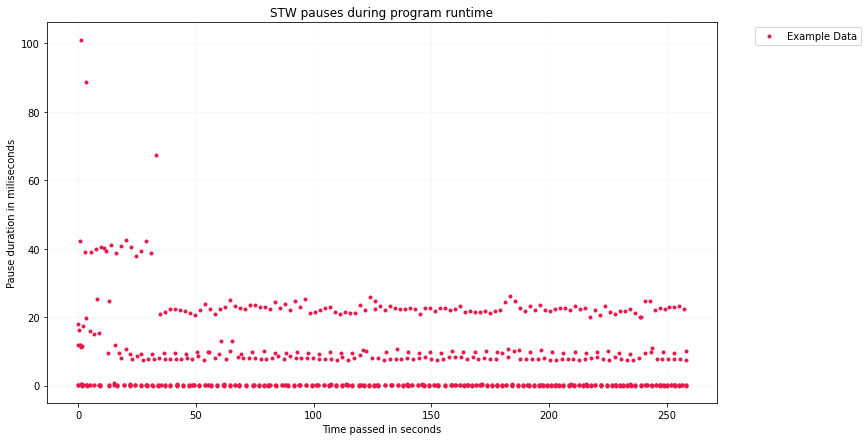

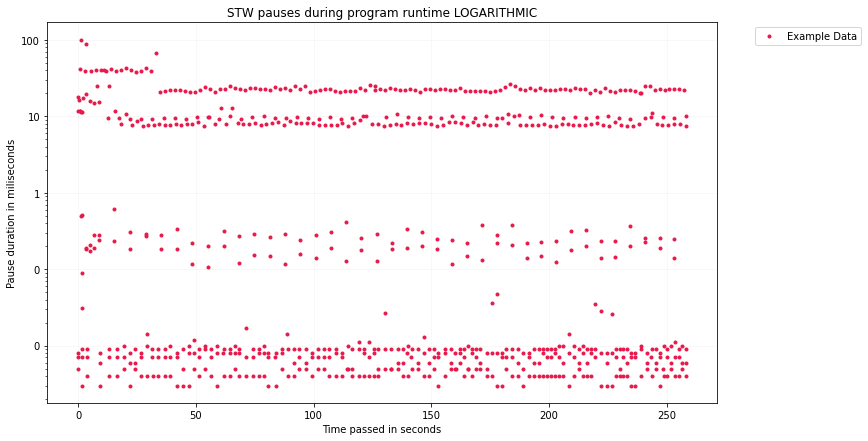

In [4]:
from src.graphing.plotting import plot_scatter

# Define a filter for searching for pauses in a gc_event_dataframe row. Will be reused throughout notebook
def pauses_only(row):
    if "EventType" in row:
        if row["EventType"] == "Pause":
            return True
    return False 

# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels=labels)

# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)

############################################################################################################
# Chart #2, logarithmic Y axis

plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)
_ = plot.set_title("STW pauses during program runtime LOGARITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)

# Set logarithmic scale 
from matplotlib.ticker import ScalarFormatter
plot.set_yscale("log") 
plot.yaxis.set_major_formatter(ScalarFormatter())

## 2. STW Pauses during program runtime
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#2a-stw-pauses-during-program-runtime-group-by-eventname-linear)

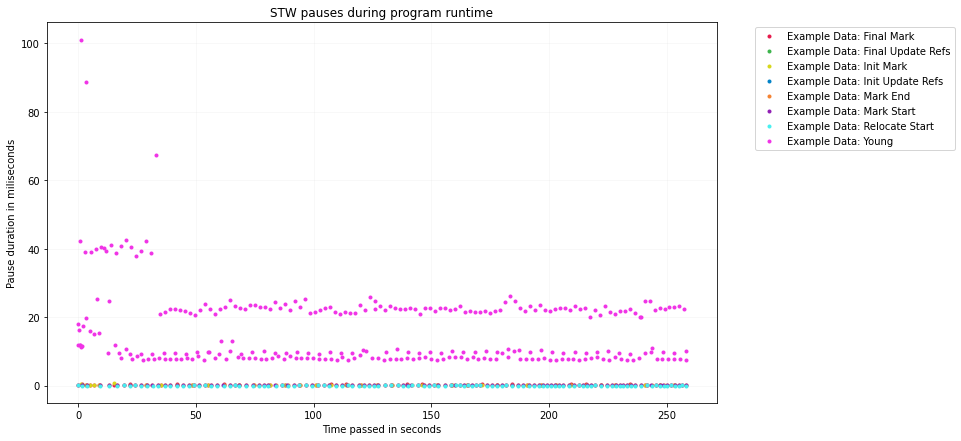

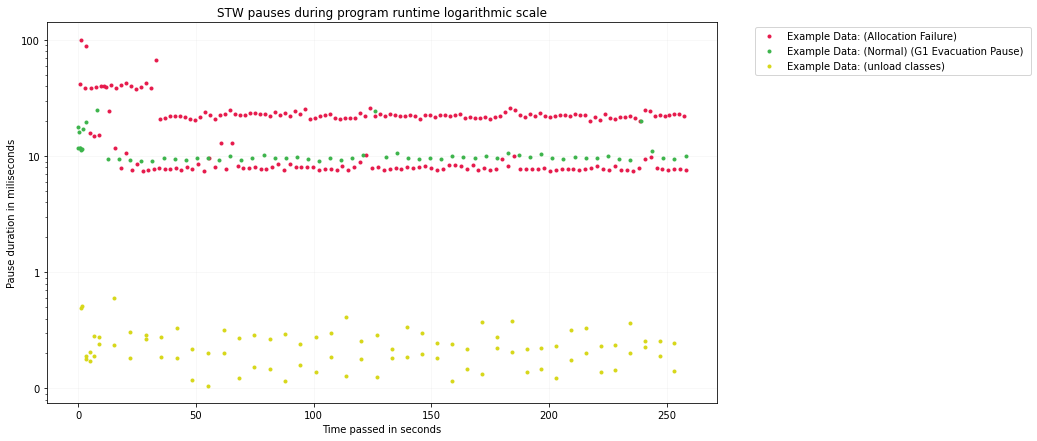

In [5]:
from src.graphing.plotting import plot_scatter
# Chart #1, linear Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels=labels, group_by = "EventName")
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)

############################################################################################################

# Chart #2, logarithmic Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only,
                    labels = labels, group_by = "AdditionalEventInfo")
_ = plot.set_title("STW pauses during program runtime logarithmic scale")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)

# Set log scale
from matplotlib.ticker import ScalarFormatter
plot.set_yscale("log") 
plot.yaxis.set_major_formatter(ScalarFormatter())

## 3. Concurrent durations during runtime
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#3-concurrent-durations-during-runtime)

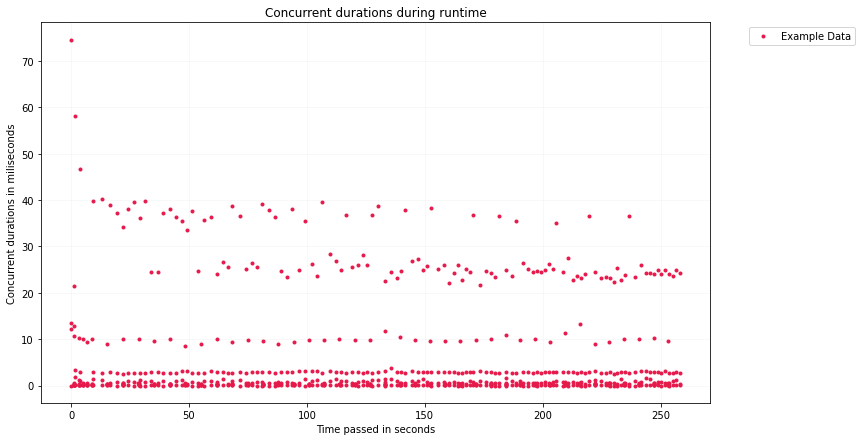

In [6]:
from src.graphing.plotting import plot_scatter

# Define a filter for capturing concurrent_only values
def concurrent_only(row):
    if "EventType" in row:
        if row["EventType"] == "Concurrent":
            return True
    return False

# Linear Graph
plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
_ = plot.set_title("Concurrent durations during runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)

# '''Logarithmic graph : Uncomment to view'''
# plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
# _ = plot.set_title("Concurrent durations during runtime LOGRITHMIC")
# plot.set_xlabel("Time passed in seconds")
# plot.set_ylabel("Concurrent durations in miliseconds")
# plot.grid(alpha = 0.1)

# # Set log scale
# from matplotlib.ticker import ScalarFormatter
# plot.set_yscale("log") 
# plot.yaxis.set_major_formatter(ScalarFormatter())

 ## 4. Total time spent in STW pauses vs. Concurrent durations
 [help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#4-total-time-spent-in-stw-pauses-vs-concurrent-durations)

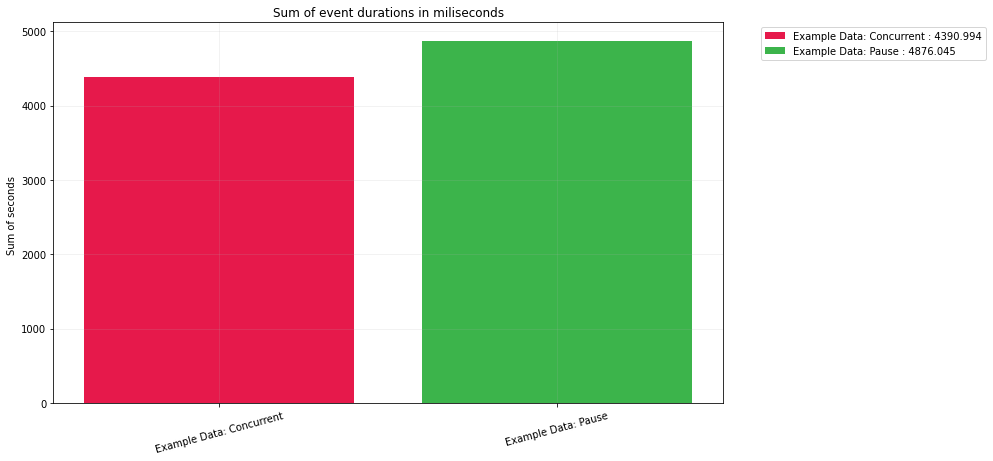

In [7]:
from src.graphing.plotting import plot_bar_sum

# Define a filter to confirm there is an event duration.
def duration_present(row):
    if "Duration_miliseconds" in row:
        if row["Duration_miliseconds"]:
            return True
    return False
    
# The grouping by eventtype means that every matching event name lives in one group. 
# Example: "Concurrent" events are a group, and "Pause" events are a group
plot = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
_ = plot.set_title("Sum of event durations in miliseconds")
_ = plot.set_ylabel("Sum of seconds ")
_ = plt.xticks(rotation = 15)
plot.grid(alpha = 0.2)

## 5. Pauses Trends 
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#5a-pauses-trends-max-sum-mean-count-stddev)

In [8]:
from src.graphing.plotting import plot_trends

# Print trends in ASCII format
print("\t\t\tPauses during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       filter_by = pauses_only,
       labels= labels,
       throughput=True)
print("\n\n\t\t\tPauses by name during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       group_by = "EventName",
       filter_by = pauses_only,
       labels = labels)

			Pauses during runtime
------------------------------------------------------------------------------------------------------------------
  Trends (ms)   | Event Count   | Max Duration  | Sum Duration  | Mean Duration | Std Dev.      | Throughput    |
-----------------------------------------------------------------------------------------------------------------
Example Data    |      727.0000 |      101.0630 |     4876.0450 |        6.7071 |       10.8559 |       98.1100 % 


			Pauses by name during runtime
------------------------------------------------------------------------------------------------------------------
Legend: 
A | Example Data: Final Mark
B | Example Data: Final Update Refs
C | Example Data: Init Mark
D | Example Data: Init Update Refs
E | Example Data: Mark End
F | Example Data: Mark Start
G | Example Data: Relocate Start
H | Example Data: Young
-------------------------------------------------------------------------------------------------
  Trends (ms)   | E

## 6. Pause percentiles 
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#6a-pause-percentiles)

In [9]:
from src.graphing.plotting import plot_percentiles

print("\t\t\tPause percentiles during runtime\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       filter_by = pauses_only,
       labels= labels)
print("\n\n\t\t\tPause percentiles during runtime by name\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       group_by = "EventName",
       filter_by= pauses_only,
       labels= labels)

			Pause percentiles during runtime
----------------------------------------------------------------------------------
Legend (All timing in miliseconds) : 
A | Example Data
-------------------------------------------------------------------------------------------------
    |                50% |                95% |                99% |             99.99% | 
------------------------------------------------------------------------------------------------
  A |             0.1430 |            23.4013 |            40.6640 |           100.1713 | 


			Pause percentiles during runtime by name
----------------------------------------------------------------------------------
Legend (All timing in miliseconds) : 
A | Example Data: Final Mark
B | Example Data: Final Update Refs
C | Example Data: Init Mark
D | Example Data: Init Update Refs
E | Example Data: Mark End
F | Example Data: Mark Start
G | Example Data: Relocate Start
H | Example Data: Young
-----------------------------------------

## 7. Mean & Sum of Event Durations
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#7a-mean-event-durations)

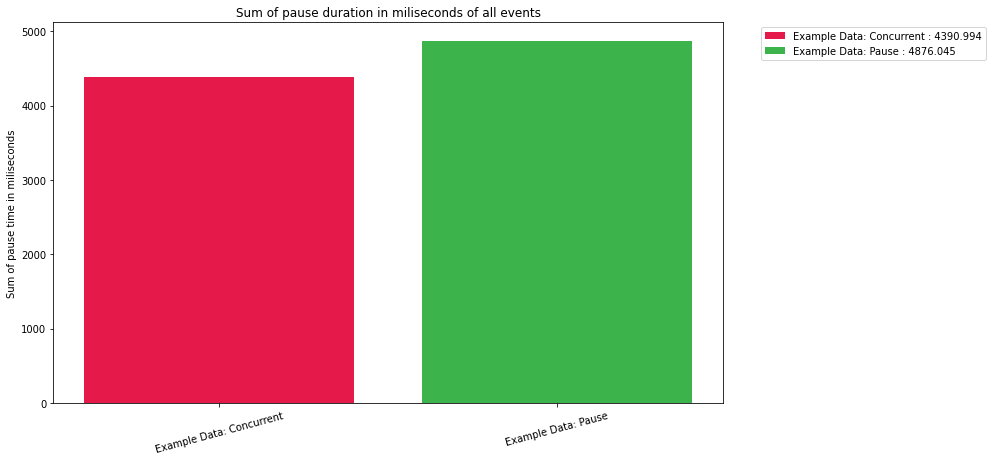

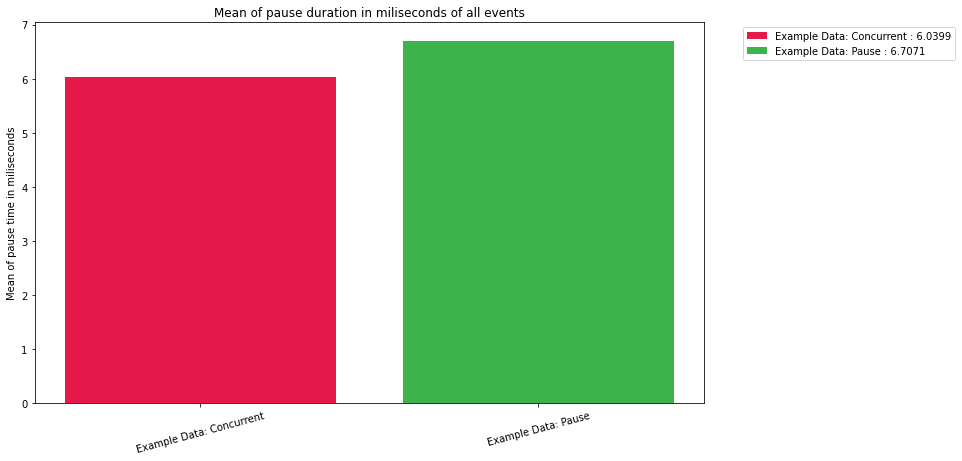

In [10]:
from src.graphing.plotting import plot_bar_sum, plot_bar_avg
# Define a filter that allows for either Concurrent or Pause eventTypes.
def concurrent_or_pauses(row):
    if "EventType" in row:
        if row["EventType"] == "Concurrent" or row["EventType"] == "Pause":
            return True
    return False
# Sum time during program runtime
plot = plot_bar_sum(gc_event_dataframes,
                    group_by = "EventType", 
                    labels = labels, 
                    filter_by = concurrent_or_pauses)
plot.yaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # Removes scientifc notation
_ = plot.set_title("Sum of pause duration in miliseconds of all events")
_ = plot.set_ylabel("Sum of pause time in miliseconds")
_ = plt.xticks(rotation = 15)

#Averages
graph = plot_bar_avg(gc_event_dataframes, 
                    group_by = "EventType", 
                    labels = labels, 
                    filter_by = concurrent_or_pauses)
_ = graph.set_title("Mean of pause duration in miliseconds of all events")
_ = graph.set_ylabel("Mean of pause time in miliseconds")
_ = plt.xticks(rotation = 15)

## 8. Heap before & after GC
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#8a-heap-before-gc)

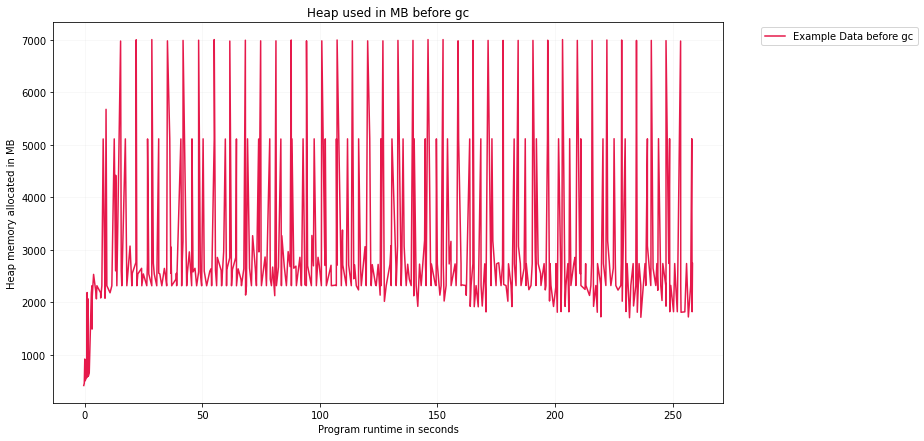

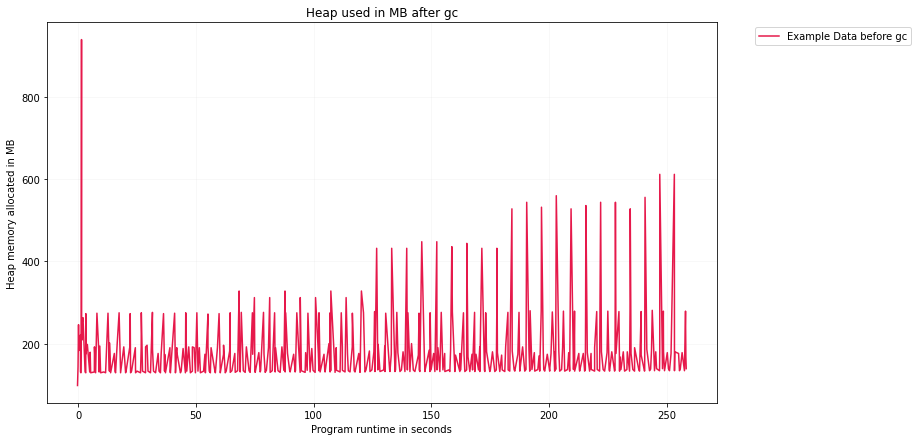

In [11]:
from src.graphing.plotting import plot_scatter, plot_line

# Sort the values in the dataframe, for the case where many associated log files for one run are grouped, and a line plot is generated.
for df in gc_event_dataframes:
    if "TimeFromStart_seconds" in df:
        df.sort_values(by="TimeFromStart_seconds", axis=0,inplace=True)

# Create filters
def heap_before_gc(row):
    if "HeapBeforeGC" in row:
        if row["HeapBeforeGC"]:
            return True
    return False

def heap_after_gc(row):
    if "HeapAfterGC" in row:
        if row["HeapAfterGC"]:
            return True
    return False

# Plot before
#   NOTE: if you would rather see a scatter plot, replace the function call to "plot_line(...)"
#         with a function call to "plot_scatter(...)"
plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = heap_before_gc,
            labels = [label + " before gc" for label in labels], 
            column = "HeapBeforeGC")
plot.set_title("Heap used in MB before gc")
plot.set_ylabel("Heap memory allocated in MB")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

# Plot After
plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = heap_after_gc,
            labels = [label + " before gc" for label in labels],
            column = "HeapAfterGC")
            
plot.set_title("Heap used in MB after gc")
plot.set_ylabel("Heap memory allocated in MB")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

## 9. MB reclaimed during program runtime
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#9-mb-reclaimed-during-program-runtime)

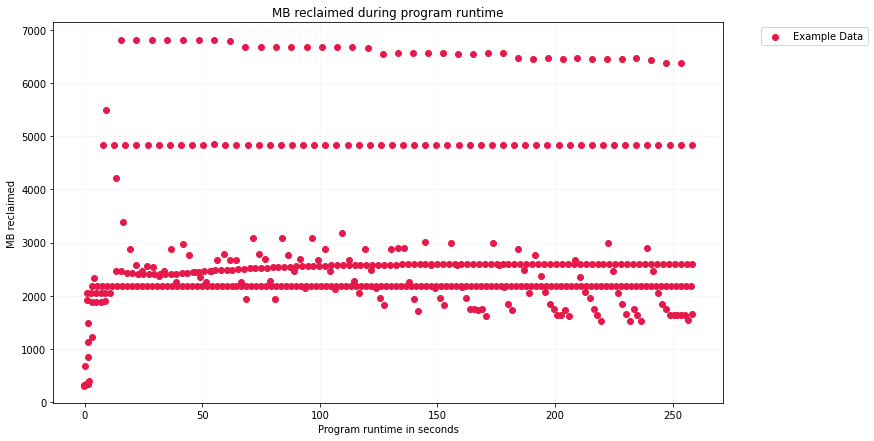

In [12]:
from src.graphing.plotting import plot_reclaimed_bytes

# Define a filter to confirm both automatically parsed regions for heap space are present
def gc_values_present(row):
    if "HeapBeforeGC" in row and "HeapAfterGC":
        if row["HeapBeforeGC"] != None and row["HeapAfterGC"] != None:
            return True
    return False

plot = plot_reclaimed_bytes(gc_event_dataframes, filter_by = gc_values_present, labels = labels)
plot.set_title("MB reclaimed during program runtime")
plot.set_ylabel("MB reclaimed")
plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)

## 10. Latency Heatmaps, Linear
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#10-latency-heatmaps-linear)

/Users/ellisbrown/Desktop/GCGC/src/notebooks/../../src/graphing/heatmap.py:115: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("plasma").copy()
  cmap.set_under('white')


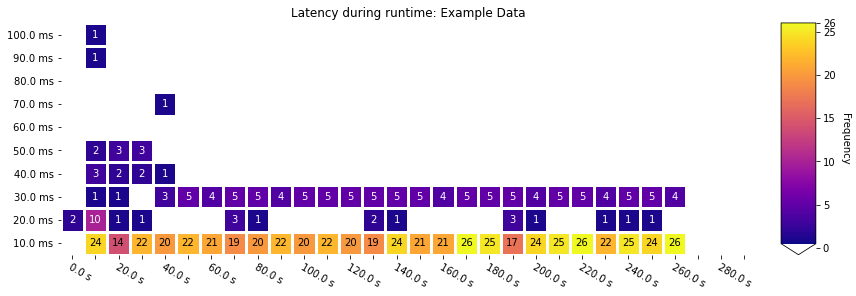

In [22]:
from src.graphing.plotting import plot_heatmaps

number_x_intervals  = 30
number_y_intervals  = 10
duration_x_interval = 10 # seconds
duration_y_interval = 10 # miliseconds

# Dimensions packs the parameters into one object
dimensions = [number_x_intervals,
              number_y_intervals,
              duration_x_interval,
              duration_y_interval] 

frequency_ticks = True
plot_heatmaps(gc_event_dataframes,
            dimensions, 
            filter_by = pauses_only, 
            labels=labels,
            frequency_ticks = frequency_ticks)

## 11. Pause Frequencies Histogram
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#11-pause-frequencies-histogram)

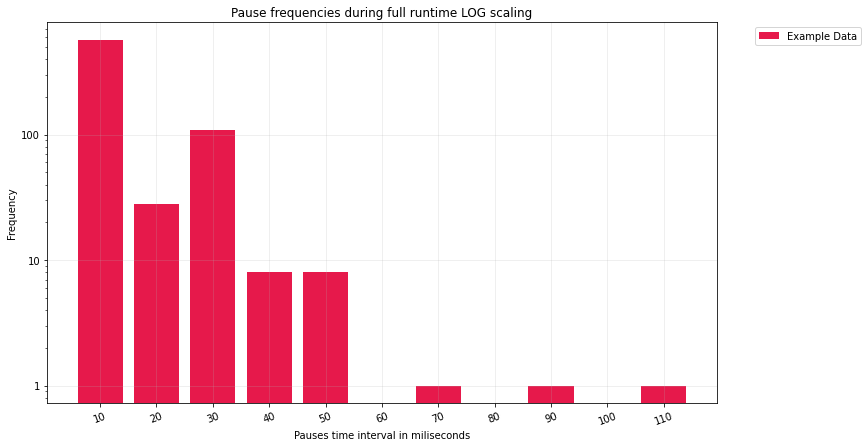

In [26]:
from src.graphing.plotting import plot_frequency_intervals

# All intervals are in seconds
plot = plot_frequency_intervals(gc_event_dataframes,
                         filter_by = pauses_only,
                         interval_duration = 10,                          
                         labels = labels)
                         
_ = plt.xticks(rotation = 20)
plot.set_xlabel("Pauses time interval in miliseconds")
plot.set_ylabel("Frequency")
plot.set_title("Pause frequencies during full runtime LOG scaling")
plot.set_yscale("log")
plot.grid(alpha = 0.25)

plot.yaxis.set_major_formatter(ScalarFormatter())


## 12. Latency percentiles over time intervals
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#12-latency-percentiles-over-time-intervals)

Percentiles plotted:  [99.9, 90, 50]


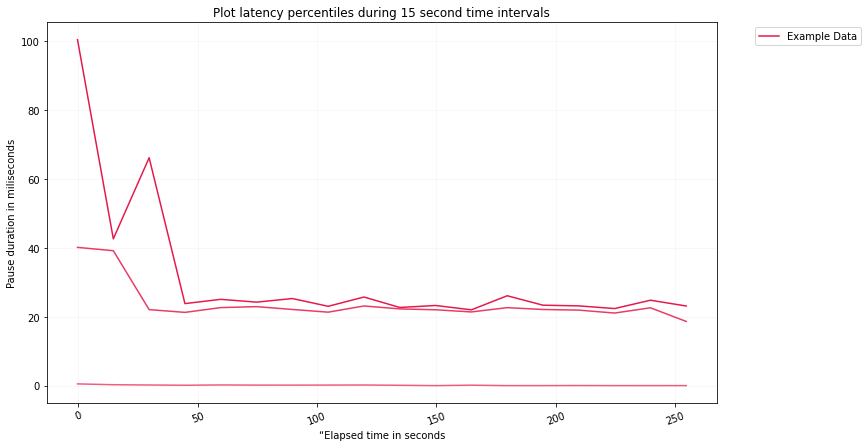

In [15]:
from src.graphing.plotting import plot_percentile_intervals
interval_duration = 15 
percentiles = [99.9, 90, 50] # Choose the percentiles to be plotted.
plot = plot_percentile_intervals(gc_event_dataframes, 
                                filter_by = pauses_only,
                                interval_duration = interval_duration ,
                                labels = labels,
                                percentiles = percentiles,
                                different_colors= False, # Set to true to have a unique color for each line on graph
                                line_graph = True)
plot.set_ylabel("Pause duration in miliseconds")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Plot latency percentiles during "+ str(interval_duration) + " second time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)
print("Percentiles plotted: ", percentiles)

## 13. Number of times GC invoked over time intervals
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#12-latency-percentiles-over-time-intervals)

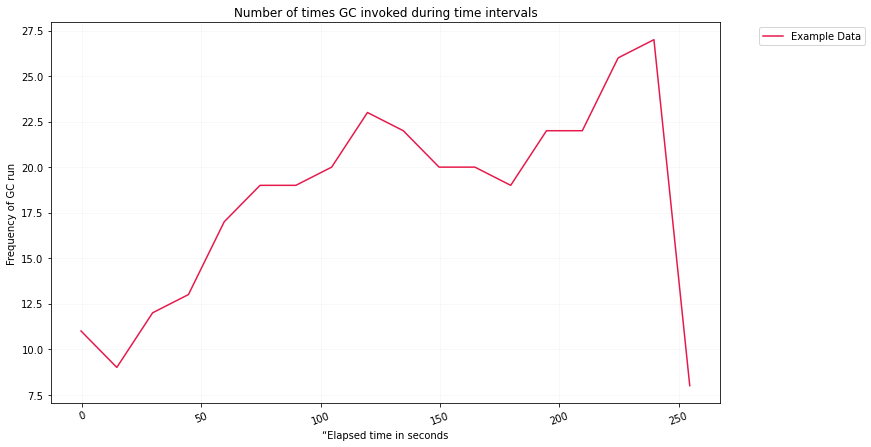

In [16]:
from src.graphing.plotting import plot_frequency_of_gc_intervals
interval_duration = 15
plot = plot_frequency_of_gc_intervals(gc_event_dataframes, 
                                      filter_by = pauses_only, 
                                      interval_duration = interval_duration,
                                      labels = labels)
plot.set_ylabel("Frequency of GC run")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Number of times GC invoked during time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)


## 14. Sum of pause durations over intervals
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#14-sum-of-pause-durations-over-intervals)

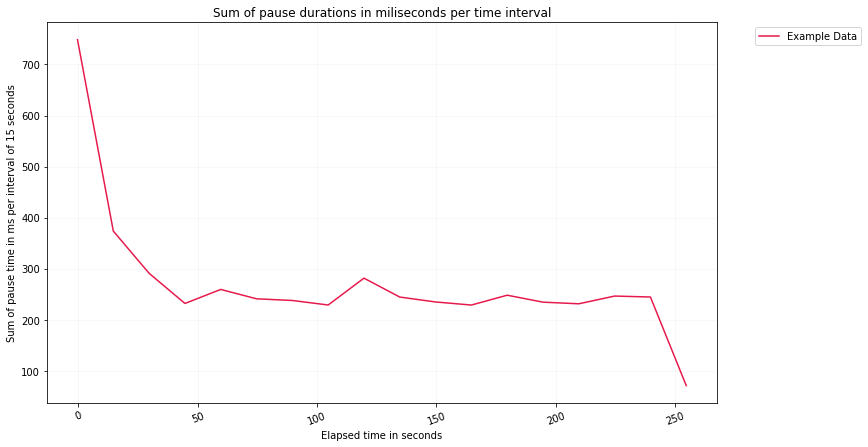

In [17]:
from src.graphing.plotting import plot_sum_pause_intervals

interval_duration = 15
plot = plot_sum_pause_intervals(gc_event_dataframes,
                                filter_by = pauses_only,
                                interval_duration = interval_duration, 
                                labels = labels,
                                line_graph = True )
_ = plot.set_title("Sum of pause durations in miliseconds per time interval")
plot.set_ylabel("Sum of pause time in ms per interval of " + str(interval_duration) + " seconds", )
plot.set_xlabel("Elapsed time in seconds")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

## 15. Logarithmic heatmaps
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#15-logarithmic-heatmaps)

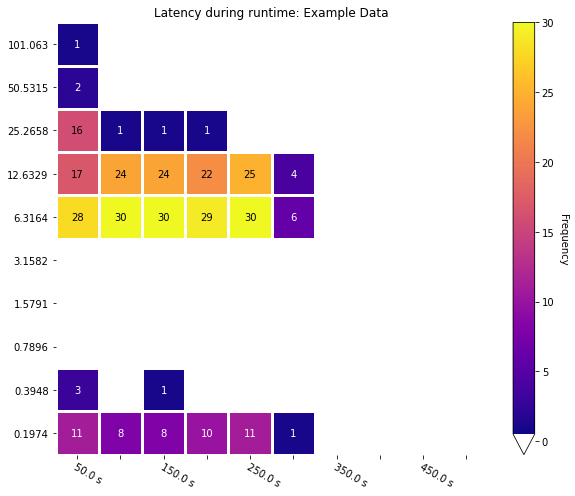

In [18]:
from src.graphing.plotting import plot_heatmaps_logarithmic
dimensions = [10, 10, 50, 2]
# [ x bucket count, y bucket count, x timestamp count, base]
frequency_ticks = True
plot_heatmaps_logarithmic(gc_event_dataframes,dimensions, filter_by = pauses_only, labels=labels, frequency_ticks = frequency_ticks)


## 16. Percentage of heap filled after GC run
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#16-percentage-of-heap-filled-after-gc)

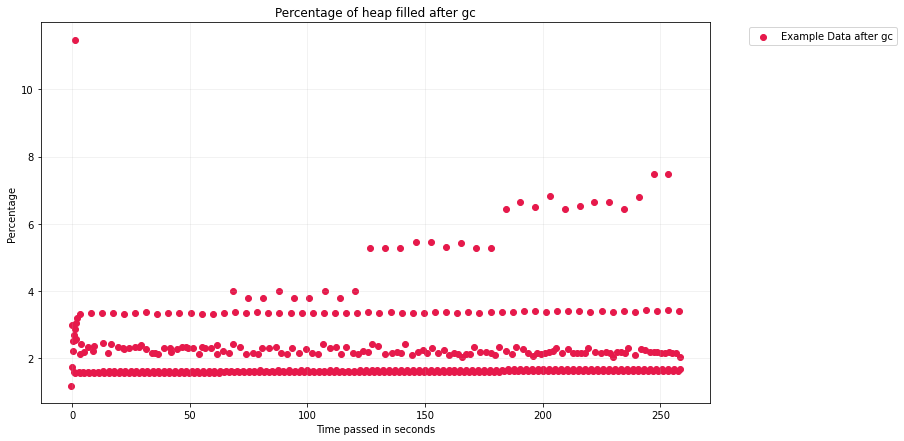

In [19]:
from src.graphing.plotting import plot_percentages

const_heapsize = 1024 * 8
plot = plot_percentages(gc_event_dataframes, 
                        filter_by = heap_before_gc,
                        labels = [label + " after gc" for label in labels],
                        # Important. The following line requires an independent entry for heapsize in MB for each log run to analyze
                        max_heapsize_list = [const_heapsize ,const_heapsize, const_heapsize],
                        column = "HeapAfterGC",
                        line_graph = False)
plot.set_title("Percentage of heap filled after gc")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Percentage")
plot.grid(alpha = 0.2)



## 17. Heap Allocation Rate
[help](https://github.pie.apple.com/ellis-brown/GCGC/blob/version0.9.2/src/notebooks/README.md#17-heap-allocation-rate)

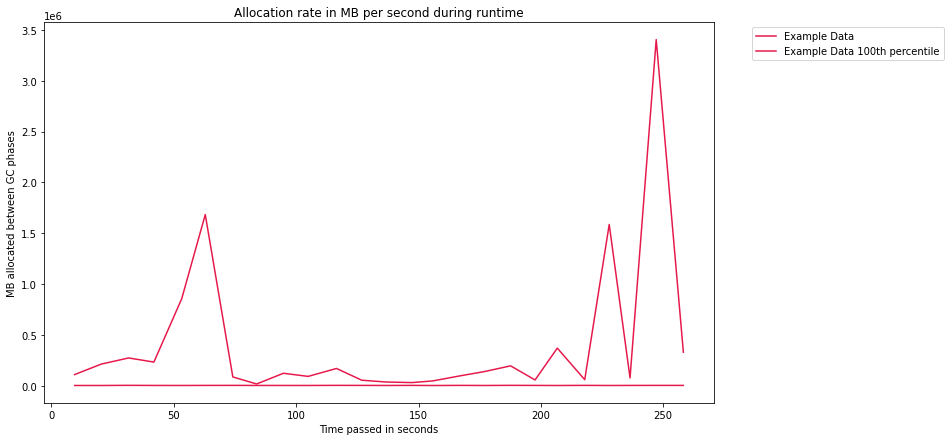

In [28]:
from src.graphing.plotting import allocation_rate
def diff_in_entries_filter(row):
    if "HeapBeforeGC" in row and "HeapAfterGC" in row:
        if row["HeapBeforeGC"] and row["HeapAfterGC"]:
            return True
    return False

interval_seconds = 10
percentile = 100

plot = allocation_rate(gc_event_dataframes,
                             filter_by = diff_in_entries_filter,
                             interval_duration= interval_seconds,
                             labels = labels,
                             line_graph=True)
plot = allocation_rate(gc_event_dataframes,
                             filter_by = diff_in_entries_filter,
                             interval_duration= interval_seconds,
                             labels = [label +" " +str(percentile) + "th percentile" for label in labels],
                             percentile = percentile,
                             plot = plot,
                             line_graph=True)                           
plot.set_title("Allocation rate in MB per second during runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("MB allocated between GC phases")
plot.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

## 18. Example of importing external data for analysis.

The following cell is NOT useful for analysis, but helps build intuition on how one may import external data. 

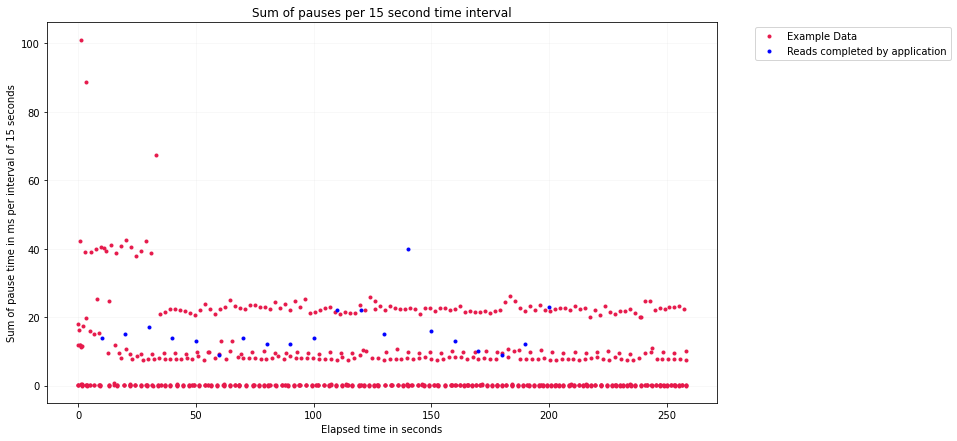

In [29]:
from src.graphing.plotting import plot_sum_pause_intervals

# First, normally plot a scatterplot
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)

plot.set_title("Sum of pauses per " + str(interval_duration) + " second time interval")
plot.set_ylabel("Sum of pause time in ms per interval of " + str(interval_duration) + " seconds", )
plot.set_xlabel("Elapsed time in seconds")
plot.grid(alpha = 0.1)

# Import the CSV data, then plot in the same cell using the
# same 'plot' object returned from the above graphing function.    
csv_data = pd.read_csv("../../datasets/example_external_data.csv")

# Plot the data.
plot = plot_scatter([csv_data], # must be a list
                    column = "Reads Completed",
                    column_timing="Time Seconds",
                    labels = ["Reads completed by application"],
                    plot = plot,
                    colors = ["blue"])